# Homework - Classification II

***Agata Makarewicz***

*Week 8 & 9*

## Introduction

In [203]:
# loading packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

import nltk
from nltk import word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
from collections import Counter,defaultdict
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn import metrics
from wordcloud import WordCloud,STOPWORDS

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

#### Basic information about the dataset

In [2]:
from bds_courseware import read_drive_dataset, HOMEWORK_DATASETS

name = "movies"
data = read_drive_dataset(*HOMEWORK_DATASETS[name])

In [3]:
data.shape

(50000, 2)

In [4]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


We can see that we have only two columns - `review` and `sentiment`, and none of them contains missing values. We can also spot some "words" which we will drop later on, such as HTML tags.

Let's take a closer look how one review looks like.

In [6]:
data.loc[0]['review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Let's now see how long (on average) our reviews are.

In [7]:
letters = [len(row) for row in data['review']] # letter count
splitted = [x.split() for x in data['review']] # word count
words = [len(x) for x in splitted]

In [8]:
stats = pd.concat([pd.DataFrame(letters).rename(columns={0: 'n_letters'}),
                   pd.DataFrame(words).rename(columns={0: 'n_words'})], axis=1)
stats.describe()

,n_letters,n_words
count,50000.000000,50000.000000
mean,1309.431020,231.156940
std,989.728014,171.343997
min,32.000000,4.000000
25%,699.000000,126.000000
50%,970.000000,173.000000
75%,1590.250000,280.000000
max,13704.000000,2470.000000


We can see that shortest review has only 4 words, but it can be misleading - we are now performing very basic EDA and splitting words by `space`, but it is possible that someone forgot to put it after a comma. Let's check out this record.

In [9]:
data['review'][np.argmin(stats['n_words'])]

'Primary plot!Primary direction!Poor interpretation.'

There are in fact 6 words instead of four in this review. Later on we will perform tokenization which will handle such situations as missing spaces between words (splitting the words better).

But we are interested in distinction between positive and negative reviews - let's check how it looks like for each of them.

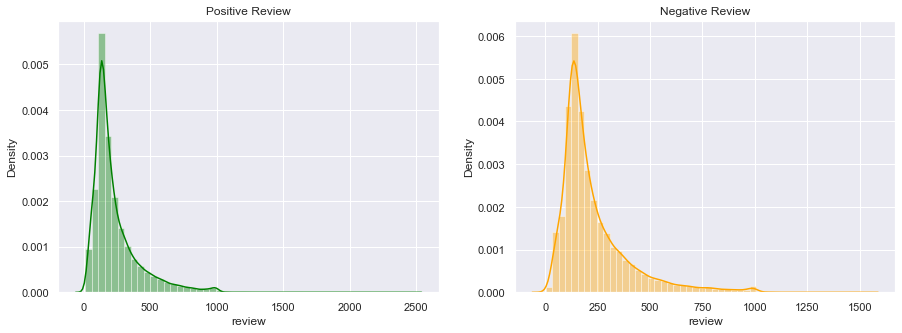

In [10]:
def plot_count(count1,count2,title_1,title_2):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    sns.distplot(count1,ax = ax1,color = 'Green')
    ax1.set_title(title_1)
    sns.distplot(count2,ax = ax2,color = 'Orange')
    ax2.set_title(title_2)
    plt.show()    

count_good = data.query('sentiment=="positive"')['review'].str.split().apply(lambda z: len(z))
count_bad = data.query('sentiment=="negative"')['review'].str.split().apply(lambda z: len(z))
plot_count(count_good,count_bad,"Positive Review","Negative Review")

In [11]:
stats2 = pd.concat([pd.DataFrame(count_good).rename(columns={'review': 'count_good'}),
                   pd.DataFrame(count_bad).rename(columns={'review': 'count_bad'})], axis=1)
stats2.describe()

,count_good,count_bad
count,25000.000000,25000.000000
mean,232.849320,229.464560
std,177.497046,164.947795
min,10.000000,4.000000
25%,125.000000,128.000000
50%,172.000000,174.000000
75%,284.000000,278.000000
max,2470.000000,1522.000000


There's practically no difference between the length of positive and negative reviews - one thig we can observe is that there are more longer reviews in case of positives (but they are rare). Further EDA will be performed after cleaning & tokenization.

#### Target analysis

positive    25000
negative    25000
Name: sentiment, dtype: int64


<AxesSubplot:xlabel='sentiment', ylabel='count'>

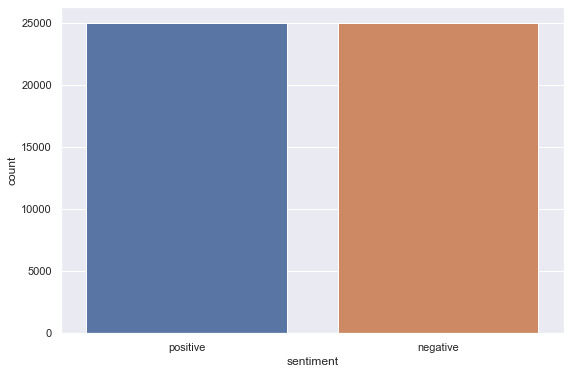

In [12]:
print(data.sentiment.value_counts())
sns.countplot(data['sentiment'])

As we can see, our target is perfectly balanced. Let's change it to binary one.

In [13]:
data['sentiment'] = data['sentiment'].replace({'positive':1,'negative':0})

### Preprocessing

#### Cleaning

In [14]:
# Remove HTML 
def clean_html(data):
    html_clean = re.compile(r'<.*?>')
    data = html_clean.sub(r'',data)
    return data

In [15]:
# Remove URL 
def clean_url(data):
    url_clean = re.compile(r"https://\S+|www\.\S+")
    data = url_clean.sub(r'',data)
    return data

In [16]:
# Modify to lower
def clean_to_lower(text):
    return text.lower()

In [17]:
# Remove punctuations
def clean_special_char(data): # and numbers
    data = re.sub('\[[^]]*\]', ' ', data)
    data = re.sub('[^a-zA-Z]', ' ', data)
    return data

In [18]:
# all cleaning together
def clean_data(data):
    data = data.apply(clean_html).apply(clean_url).apply(clean_to_lower).apply(clean_special_char)
    return data

#### Tokenization

In [19]:
def tokenize(row):
    token = word_tokenize(row) 
    filtered_token = []
    for word in token:
        if word not in stopwords.words('english'):
            filtered_token.append(word)
    return filtered_token

#### Stemming

In [73]:
def stemmer(data):
    porter = PorterStemmer()
    text = [porter.stem(row) for row in data]
    text = " ".join(text)
    return text

#### Lemmatization

In [74]:
def lemmatizer(data):
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(row) for row in data]
    text = " ".join(text)
    return text

### Modeling

#### Train-test split

In [45]:
data2 = data[0:500]

In [46]:
data_train, data_test, target_train, target_test = train_test_split(data2['review'], data2['sentiment'], 
                                                                    test_size=0.20, shuffle=True, random_state=123)

In [47]:
# cleaning & tokenization
data_train_clean = clean_data(data_train)
data_test_clean = clean_data(data_test)

data_train_tok = data_train_clean.apply(tokenize_and_remove_stopwords)
data_test_tok = data_test_clean.apply(tokenize_and_remove_stopwords)

In [51]:
data_train_clean

199    the film quickly gets to a major chase scene w...
450    i was drawn to  friends  by the soundtrack sco...
231    i think this is one hell of a movie           ...
95     daniel day lewis is the most versatile actor a...
54     the    percent of the nations nitwits that sti...
                             ...                        
98     this is the worst movie i have ever seen  as w...
476    i shall begin with a disclaimer  this movie is...
322    if only i had read the review by alex sander  ...
382    for his first ever debut this film has some ri...
365    years ago  when darling lili played on tv  it ...
Name: review, Length: 400, dtype: object

In [186]:
# Function to plot wordcloud
def plot_wordcloud(data):
    words = '' 
    for token in data: 
        words += " ".join(token)+" "
            

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', stopwords=['movie','film','character','one','show','even','like','time','get'],
                    min_font_size = 10).generate(words)                        
    plt.figure(figsize = (9,6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.show()

In [187]:
positive_ind = target_train[target_train==1].index.to_list()
negative_ind = target_train[target_train==0].index.to_list()

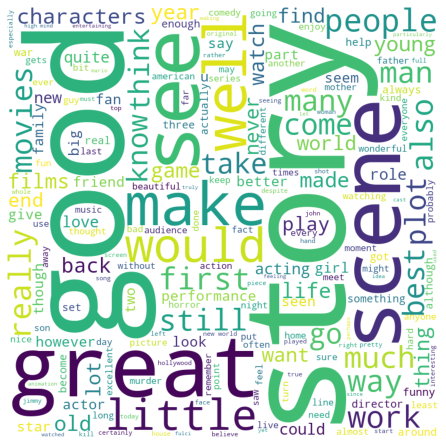

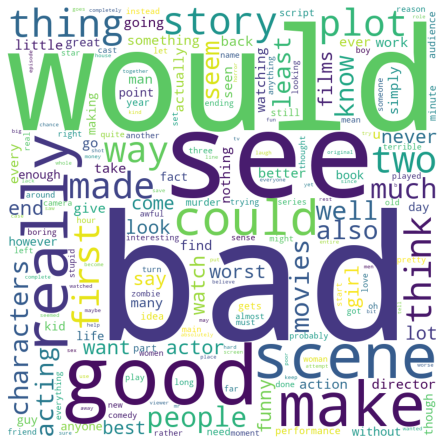

In [188]:
plot_wordcloud(data_train_tok[positive_ind])
plot_wordcloud(data_train_tok[negative_ind])


In [184]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [75]:
# stemming & lemmatization
data_train_stem = data_train_tok.apply(stemmer)
data_train_lemma = data_train_tok.apply(lemmatizer)
data_test_stem = data_test_tok.apply(stemmer)
data_test_lemma = data_test_tok.apply(lemmatizer)

In [189]:
def count_words(data):
    ngram_vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=1)
    X = ngram_vectorizer.fit_transform(data_test_lemma)
    vocab = list(ngram_vectorizer.get_feature_names())
    counts = X.sum(axis=0).A1
    freq_distribution = Counter(dict(zip(vocab, counts)))
    print (freq_distribution.most_common(10))

In [91]:
stop_words_lemma = [WordNetLemmatizer().lemmatize(t) for t in stopwords.words('english')]
stop_words_stem = [PorterStemmer().stem(t) for t in stopwords.words('english')]

In [192]:
count_words(data_train_tok)

[('movie', 249), ('film', 231), ('like', 108), ('one', 106), ('even', 69), ('see', 62), ('would', 61), ('character', 57), ('really', 57), ('get', 56)]


In [200]:
tokens=[t for t in .split(" ")]
print(tokens[:2])
print(data_test_tok[:2])
ngrams=zip(*[tokens[i:] for i in range(2)])
print(ngrams)
final_tokens=[" ".join(z) for z in ngrams]
print(final_tokens[:2])

AttributeError: 'Series' object has no attribute 'split'

In [216]:
# creating bi-grams frequency charts
def grams(data,gram):
    tokens = [t for t in data]
    ngrams = zip(*[tokens[i:] for i in range(gram)])
    final_tokens = [" ".join(z) for z in ngrams]
    return final_tokens
    
def create_dict(data,grams):
    freq_dict = defaultdict(int)
    for sentence in data:
        for tokens in gram_analysis(sentence,grams):
            freq_dict[tokens] += 1
    return freq_dict

def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y = df["n_gram_words"].values[::-1],
        x = df["n_gram_frequency"].values[::-1],
        showlegend = False,
        orientation = 'h',
        marker = dict(color=color,),)
    return trace

def create_freq_df(freq_dict,):
    freq_df = pd.DataFrame(sorted(freq_dict.items(),key=lambda z:z[1])[::-1])
    freq_df.columns = ['n_gram_words','n_gram_frequency']
    trace = horizontal_bar_chart(freq_df[:10],'lightblue')
    return trace
    
def plot_grams(negative,positive):
    fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Negative reviews", "Positive reviews"])
    fig.append_trace(negative, 1, 1)
    fig.append_trace(positive, 1, 2)
    fig['layout'].update(height=400, width=800, paper_bgcolor='rgb(233,233,233)', title="Word Count")
    py.iplot(fig, filename='word-plots')

train_bad = data_train_tok[negative_ind]
train_good = data_train_tok[positive_ind]

print("Bi-gram analysis")
freq_bad = create_dict(train_bad,2)
neg = create_new_df(freq_bad)
freq_good = create_dict(train_good,2)
pos = create_new_df(freq_good)
plot_grams(neg,pos)

print("Tri-gram analysis")
freq_bad = create_dict(train_bad,3)
neg = create_new_df(freq_bad)
freq_good=create_dict(train_good,3)
pos = create_new_df(freq_good)
plot_grams(neg,pos)

Bi-gram analysis


Tri-gram analysis


In [217]:
data_train_tok[negative_ind]

199    [film, quickly, gets, major, chase, scene, eve...
54     [percent, nations, nitwits, still, support, w,...
309    [best, film, derek, couple, ever, made, think,...
346    [anyone, edit, film, dvd, release, huge, thirt...
155    [standard, view, purely, awful, movie, however...
                             ...                        
17     [movie, made, one, top, awful, movies, horribl...
230    [movie, really, bad, looks, like, filmed, eith...
98     [worst, movie, ever, seen, well, worst, probab...
322    [read, review, alex, sander, sic, rather, look...
365    [years, ago, darling, lili, played, tv, always...
Name: review, Length: 211, dtype: object

In [148]:
from collections import Counter
words = '' 
for token in data_test_tok: 
    words += " ".join(token)+" "
print(words[:100])
counter = Counter()
most_common = counter.most_common(20)
most_common

lucky see film part melbourne international film festival days ago must admit partial movies focus h


[]

In [149]:
ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=1)
X = ngram_vectorizer.fit_transform(data_test_lemma)

vocab = list(ngram_vectorizer.get_feature_names())

counts = X.sum(axis=0).A1

freq_distribution = Counter(dict(zip(vocab, counts)))
print (freq_distribution.most_common(10))

[('movie', 249), ('film', 231), ('like', 108), ('one', 106), ('even', 69), ('see', 62), ('would', 61), ('character', 57), ('really', 57), ('get', 56)]


#### Bag of words

#### TFIDF

#### SGD Classifier (logistic regression ?)(or SVM ?)

In [77]:
sgd_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3), max_features=150000)),
    ('model', SGDClassifier())
])

tuned_parameters = [{'model__alpha': [0.1, 0.5, 1.0, 5, 10], 
                     'model__loss': ['log'], # hinge - linear svm
                     'model__penalty': ['l2', 'l1', 'elasticnet']}]

grid_search = GridSearchCV(sgd_pipe, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='f1')

In [78]:
grid_search.fit(data_train_lemma, target_train)
#grid_search.fit(data_train_stem, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_features=150000,
                                                        ngram_range=(1, 3))),
                                       ('model', SGDClassifier())]),
             param_grid=[{'model__alpha': [0.1, 0.5, 1.0, 5, 10],
                          'model__loss': ['log'],
                          'model__penalty': ['l2', 'l1', 'elasticnet']}],
             scoring='f1')

In [79]:
grid_search.best_params_

{'model__alpha': 0.5, 'model__loss': 'log', 'model__penalty': 'elasticnet'}

In [80]:
y_pred = grid_search.predict(data_test_lemma)
#y_pred = grid_search.predict(data_test_stem)

In [81]:
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68        52
           1       0.00      0.00      0.00        48

    accuracy                           0.52       100
   macro avg       0.26      0.50      0.34       100
weighted avg       0.27      0.52      0.36       100



In [83]:
grid_search.best_estimator_.get_params()['steps'][1][1].coef_
#grid_search.best_estimator_.get_params()['steps'][0][1].get_feature_names()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [97]:
#########################################################
#########################################################
#########################################################

In [132]:
sgd_pipe2 = Pipeline([
    ('vectorizer',  CountVectorizer(max_features=1500)),
    ('model', SGDClassifier())
])

tuned_parameters = [{'model__alpha': [0.1, 0.5, 1.0, 5, 10], 
                     'model__loss': ['log'], # hinge - linear svm
                     'model__penalty': ['l2', 'l1', 'elasticnet']}]

grid_search = GridSearchCV(sgd_pipe2, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='f1')

In [133]:
grid_search.fit(data_train_lemma, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(max_features=1500)),
                                       ('model', SGDClassifier())]),
             param_grid=[{'model__alpha': [0.1, 0.5, 1.0, 5, 10],
                          'model__loss': ['log'],
                          'model__penalty': ['l2', 'l1', 'elasticnet']}],
             scoring='f1')

In [134]:
grid_search.best_params_

{'model__alpha': 0.1, 'model__loss': 'log', 'model__penalty': 'l2'}

In [135]:
y_pred = grid_search.predict(data_test_lemma)

In [136]:
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76        52
           1       0.74      0.73      0.74        48

    accuracy                           0.75       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.75      0.75      0.75       100



In [137]:
grid_search.best_estimator_.get_params()['steps'][1][1].coef_[0].shape
grid_search.best_estimator_.get_params()['steps'][0][1].get_feature_names().shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
def plot_importance(coefs, colnames):
    importance = pd.DataFrame({'Weight':coefs,'Variable': colnames})
    imp1 = importance.sort_values(by='Weight', ascending=False).head(10)
    imp2 = importance.sort_values(by='Weight', ascending=False).tail(10)
    imp = pd.concat([imp1,imp2])
    plot = sns.barplot( x='Weight',y='Variable', data=imp)
    plot.set_title('Word importance - top 10 +/-', size=14)

In [138]:
importance = pd.DataFrame({'Weight': grid_search.best_estimator_.get_params()['steps'][1][1].coef_[0],
                           'Variable': grid_search.best_estimator_.get_params()['steps'][0][1].get_feature_names()})
imp1 = importance.sort_values(by='Weight', ascending=False).head(10)
imp2 = importance.sort_values(by='Weight', ascending=False).tail(10)
imp = pd.concat([imp1,imp2])

Text(0.5, 1.0, 'Word importance - top 10 +/-')

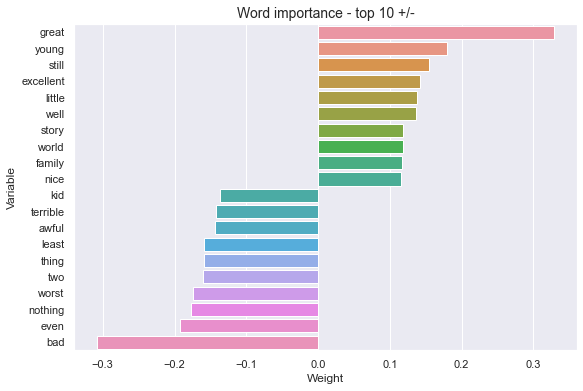

In [139]:
plot = sns.barplot( x='Weight',y='Variable', data=imp)
plot.set_title('Word importance - top 10 +/-', size=14)

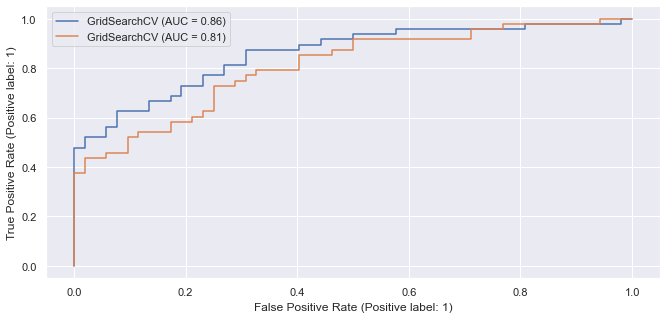

In [140]:
from sklearn.metrics import roc_auc_score, auc, plot_roc_curve, roc_curve
# plot_roc_curve(grid_search,data_test_lemma,target_test)
# plot_roc_curve(grid_search,data_test_stem,target_test)

# prepare plots
fig, ax = plt.subplots(1,1,figsize=(11, 5))

plot_roc_curve(grid_search,data_test_lemma,target_test, ax=ax)
plot_roc_curve(grid_search,data_test_stem,target_test, ax=ax)

# ax_roc.set_title('Receiver Operating Characteristic (ROC) curves')
# ax_det.set_title('Detection Error Tradeoff (DET) curves')

# ax_roc.grid(linestyle='--')
# ax_det.grid(linestyle='--')

plt.legend()
plt.show()

#### SVM

In [218]:
svm_pipe = Pipeline([
    ('vectorizer', CountVectorizer(max_features=150000)),
    ('model', SVC())
])

parameters = [{'model__kernel': ['rbf'], 
               'model__gamma': [1e-3, 1e-4],
               'model__C': [1, 10, 100, 1000]},]


grid_search = GridSearchCV(svm_pipe, param_grid=parameters,
                           cv=StratifiedKFold(3), scoring='f1')

In [219]:
grid_search.fit(data_train_lemma, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(max_features=150000)),
                                       ('model', SVC())]),
             param_grid=[{'model__C': [1, 10, 100, 1000],
                          'model__gamma': [0.001, 0.0001],
                          'model__kernel': ['rbf']}],
             scoring='f1')

In [119]:
grid_search.best_params_

{'model__C': 10, 'model__gamma': 0.001, 'model__kernel': 'rbf'}

In [120]:
y_pred = grid_search.predict(data_test_lemma)

In [121]:
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       100
           1       0.80      0.76      0.78       101

    accuracy                           0.79       201
   macro avg       0.79      0.79      0.79       201
weighted avg       0.79      0.79      0.79       201



In [118]:
svm_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(ngram_range=(1, 3), max_features=150000)),
    ('model', SVC())
])

parameters = [{'model__kernel': ['rbf'], 
               'model__gamma': [1e-3, 1e-4],
               'model__C': [1, 10, 100, 1000]},]


grid_search = GridSearchCV(svm_pipe, param_grid=parameters,
                           cv=StratifiedKFold(3), scoring='f1')

In [119]:
grid_search.fit(data_train_lemma, target_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_features=150000,
                                                        ngram_range=(1, 3))),
                                       ('model', SVC())]),
             param_grid=[{'model__C': [1, 10, 100, 1000],
                          'model__gamma': [0.001, 0.0001],
                          'model__kernel': ['rbf']}],
             scoring='f1')

In [120]:
grid_search.best_params_

{'model__C': 1000, 'model__gamma': 0.001, 'model__kernel': 'rbf'}

In [121]:
y_pred = grid_search.predict(data_test_lemma)

In [122]:
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.90      0.82        52
           1       0.87      0.69      0.77        48

    accuracy                           0.80       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100



#### Naive Bayes

In [127]:
nb_pipe = Pipeline([
    ('vectorizer',TfidfVectorizer(ngram_range=(1, 3), max_features=150000) ),
    ('model', MultinomialNB())
])

tuned_parameters = [{'model__alpha': [0, 0.5, 1.0, 5, 10], 
                     'model__fit_prior':[True, False]}]

grid_search = GridSearchCV(nb_pipe, param_grid=tuned_parameters,
                           cv=StratifiedKFold(3), scoring='f1')

In [128]:
grid_search.fit(data_train_lemma, target_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..............model__alpha=0, model__fit_prior=True; total time=   1.0s
[CV] END ..............model__alpha=0, model__fit_prior=True; total time=   1.0s
[CV] END ..............model__alpha=0, model__fit_prior=True; total time=   0.9s
[CV] END .............model__alpha=0, model__fit_prior=False; total time=   0.9s
[CV] END .............model__alpha=0, model__fit_prior=False; total time=   1.4s
[CV] END .............model__alpha=0, model__fit_prior=False; total time=   1.0s
[CV] END ............model__alpha=0.5, model__fit_prior=True; total time=   0.9s
[CV] END ............model__alpha=0.5, model__fit_prior=True; total time=   0.9s
[CV] END ............model__alpha=0.5, model__fit_prior=True; total time=   1.0s
[CV] END ...........model__alpha=0.5, model__fit_prior=False; total time=   1.3s


KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

In [ ]:
y_pred = grid_search.predict(data_test_lemma)

In [ ]:
print(classification_report(target_test, y_pred))